In [1]:
import sys
sys.path.append("..")

from core.jax import coeffs, compute_bounds, sT
from core import compute_bounds as compute_bounds_python
from jax import config
config.update("jax_enable_x64", True)

from jaxoplanet.light_curves import LimbDarkLightCurve
from jaxoplanet import light_curves, orbits

import numpy as np
import jax.numpy as jnp
from scipy.integrate import quad
from scipy.special import binom, roots_legendre
import matplotlib.pyplot as plt
%matplotlib inline

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Jaxifying the oblate planet model

In this notebook, I will use the jaxified transit model and show how to compute an oblate planet model using vmap and jit

First, lets test on the standard jaxoplanet transit model and time it:

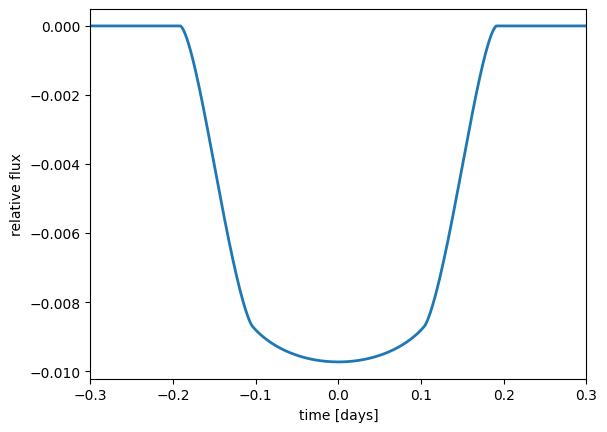

In [2]:
#Fiducial planet parameters:
params = {'period':300.456,
          'radius':0.1,
          'u':jnp.array([0.3,0.2]),
          'b':0.7,
          'bo':0.8,
}
# The light curve calculation requires an orbit

orbit = orbits.KeplerianOrbit.init(period=params['period'], radius=params['radius'], impact_param=params['bo'])

# Compute a limb-darkened light curve using starry
t = jnp.linspace(-0.3, 0.3, 1000)

lc = LimbDarkLightCurve(params['u']).light_curve(orbit, t=t)

plt.plot(t, lc[0], color="C0", lw=2)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
_ = plt.xlim(t.min(), t.max())

In [3]:
ldlc = LimbDarkLightCurve(params['u'])

In [4]:
%%timeit
lc = ldlc.light_curve(orbit, t=t)

3.33 ms ± 73.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [5]:
def greens_basis_transform(u):
    
    """ Returns the star's flux in Green's basis
    given quadratic limb darkening coefficients"""
    assert u.shape[0]==2
    g = jnp.zeros(9)
    g = g.at[0].set(1-u[0]-2*u[1])
    g = g.at[2].set(u[0] + 2*u[1])
    g = g.at[4].set(u[1]/3)
    g = g.at[8].set(u[1])
    return g

In [6]:
xo, yo = orbit.relative_position(t)[0][0],orbit.relative_position(t)[1][0]


In [7]:
from jax import vmap
import jax
compute_bounds_vec = jax.jit(vmap(compute_bounds, in_axes=(None, 0,0,None)))

In [8]:
xis_jax, phis_jax = compute_bounds_vec(params['b'],xo,yo,params['radius'])

Now, let's time the computation of the integral bounds. It takes less than a millisecond to run, compared to half a second without vectorization and compilation!

In [9]:
%% timeit
xis_jax, phis_jax = compute_bounds_vec(params['b'],xo,yo,params['radius'])

UsageError: Cell magic `%%` not found.


In [10]:
sT_vec = jax.jit(vmap(sT,in_axes=(0, 0, 0,0,None,0,0,None,None)), static_argnums=8)

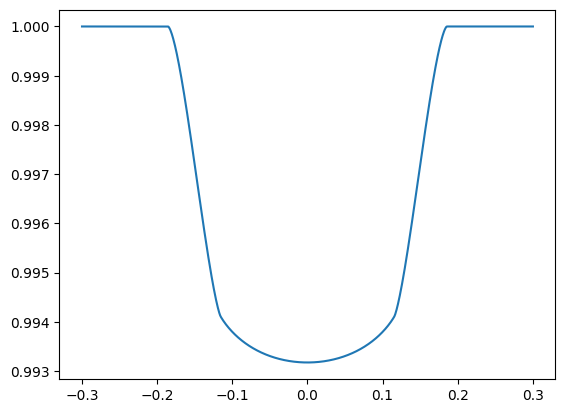

In [11]:
xis_jax, phis_jax = compute_bounds_vec(params['b'],xo,yo,params['radius'])
g = greens_basis_transform(params['u'])
ns = np.arange(len(g))
lcs = []
for n in ns:
    if g[n] != 0:
        lc = sT_vec(phis_jax[:,0],phis_jax[:,1], xis_jax[:,0],xis_jax[:,1], params['b'],xo,yo,params['radius'],n)
    else:
        lc = jnp.zeros(len(xo))
    lcs.append(lc)
    
    
lcs = jnp.array(lcs).T@g

plt.plot(t,lcs/lcs[0])

## Timing the oblate planet model:

For a light curve with 1000 points, it takes about 10ms to calculate a light curve!! That's only a factor of 3x slower than jaxoplanet!

In [12]:
%%timeit
g = greens_basis_transform(params['u'])
ns = np.arange(len(g))
lcs = []
for n in ns:
    if g[n] != 0:
        lc = sT_vec(phis_jax[:,0],phis_jax[:,1], xis_jax[:,0],xis_jax[:,1], params['b'],xo,yo,params['radius'],n)
    else:
        lc = jnp.zeros(len(xo))
    lcs.append(lc)
    
lcs = jax.block_until_ready(jnp.array(lcs).T@g)

10.5 ms ± 262 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
